# Example 6: Rocking curves

With `m2SANS` you can simulate scattering patterns for rocking curves, where either the sample or the sample environment is rotated or tilted in the neutron beam. This will affect the magnetic scattering in a variety of ways:

- First, the spatial arrangement (repectively projection) of scatterers is modified.
- Second, the magnetisation components $\vec{M}_{\perp}(\vec{Q})$ perpendicular to the scattering vector $\vec{Q}$ change, which affects the magnetic scattering lengths $\vec{b}_{\vec{M}_{\perp}}$
- Third, the neutron polarisation $\vec{P}$ is modified if the sample environment is rotated. This will affect the projections of the magnetic scattering lenght, and ultimatively the distribution of the scattering cross sections.

For this reason, one can get different scattering patterns when rotating the sample compared to rotating the sample environemnt (in which the sample is co-rotating, and leading to differnt projections of the neutron polarisation vector).

## How to simulate a rocking curve

To simulate a rocking curve, for each rotation setting you have to initialise a new `mm2SANS.Experiment` object -- which contains the transformed coordinates $\vec{R}_i$ and moments $\vec{M}_i$ of the individual scatterers and the neutron polarisation $\vec{P}$, all defined in the beamline coordinate system ($U$, $V$, $W$) -- and then calculate the scattering patterns.

To do so, follow these steps (some may be omitted, but please carefult to not overwrite settings inadvertedly):

1. Initialise your `mm2SANS.Sample` and `mm2SANS.Probe` object. This only needs to be done in the beginning. The following steps are then for each roation angle.
2. Set sample rotations and sample environment rotations in the `Probe` object. Then re-calculate the rotation matrices.
3. Initiate a new `mm2SANS.Experiment` object, which takes care of all transformations.
4. Optional: If the neutron polarisation $\vec{P}$ is _not_ set within the sample environment but within beamline coordinate system, you have to re-set the value of `mm2SANS.Experiment.Probe.Beamline.neutron_polarisation` accordingly.
5. Calculate the scattering patterns & visualise.

In [1]:
import mm2SANS

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
def compare_rotations(moment_direction, neutron_polarisation, rotation_axis, num_rotations, delta_phi, plot_property, col_limit):
    """ General function to compare effect of sample and sample environment rotations. """

    """ create the Sample object (using settings from Example 1)"""
    sample = mm2SANS.Sample(
        positions=[[0, 0, 0]],
        moments=[moment_direction],
        scattering_length_density=(8.024-0.001j),
        saturation_magnetisation=800e3,
        voxel_volumes= 4/3 * np.pi * 10e-9**3 ,
        periodicity=(50e-9, 50e-9, 50e-9),
        print_diagnostics=False,
        )

    """ create a Detector object (using Settings from Example 2) """
    probe = mm2SANS.Probe(
          sans_instrument='test'
        , neutron_wavelength=6e-10 # in m
        , detector_distance=15 # in m
        , qmap_disorder=0.35 # to avoid Fourier transform artefacts
        , neutron_polarisation=neutron_polarisation
       )
    
    """ initialise figure """
    axis_size = 2
    fig = plt.figure( figsize = (axis_size * (num_rotations+1), 2 * axis_size) )
    fig.suptitle(f'{rotation_axis} rotations - sample (top) - cryostat (bottom)', fontsize=20, y=1.05)
    gs = gridspec.GridSpec(2, (num_rotations+1) )
    
    """ iterate over rotation angles """
    rotation_list = np.arange(0, (num_rotations+1) * delta_phi, delta_phi) - num_rotations / 2 * delta_phi
    for i, phi in enumerate(rotation_list):
    
        """ sample rotations """
        probe.Beamline.sample_rotations = [[rotation_axis, phi]]
        probe.Beamline.sample_environment_rotations = []
        probe.Beamline.calc_rotation_matrices()
        experiment = mm2SANS.Experiment(sample, probe, print_diagnostics=False)
        experiment.calc_scattering_pattern(uc_repetitions=(1,1,1))
        ax = plt.subplot(gs[0, i])
        experiment.plot_property( plot_property, ax=ax, title=f'{phi} deg', limit=col_limit )
        ax.axis('off')

        """ sample environment rotations """
        probe.Beamline.sample_rotations = []
        probe.Beamline.sample_environment_rotations = [[rotation_axis, phi]]
        probe.Beamline.calc_rotation_matrices()
        experiment = mm2SANS.Experiment(sample, probe, print_diagnostics=False)
        experiment.calc_scattering_pattern(uc_repetitions=(1,1,1))
        ax = plt.subplot(gs[1, i])
        experiment.plot_property( plot_property, ax=ax, title=' ', limit=col_limit )
        ax.axis('off')
    
    return

## sphere with $\vec{M}\parallel(0,1,0)$, $\vec{P}\parallel(1,0,0)$

In the follwing, we consider a uniformly magnetised sphere along (0, 1, 0), i.e. parallel to the horizontal detector plane, and a longitudinal neutron polarisation (1, 0, 0), i.e. parallel to the beam. The sample is subjected to “yaw” rotations, which correspond to rotations around the vertical detector axis. 

In the case of the cryostat rotatation, the neutron polarisation also aquires a transverse component, which gives the pinching effect.

C:\ProgramData\Anaconda3\lib\site-packages\mm2sans-0.1-py3.6.egg\mm2SANS\experiment.py:650: UserWarning: No contour levels were found within the data range.
C:\ProgramData\Anaconda3\lib\site-packages\mm2sans-0.1-py3.6.egg\mm2SANS\experiment.py:650: UserWarning: No contour levels were found within the data range.


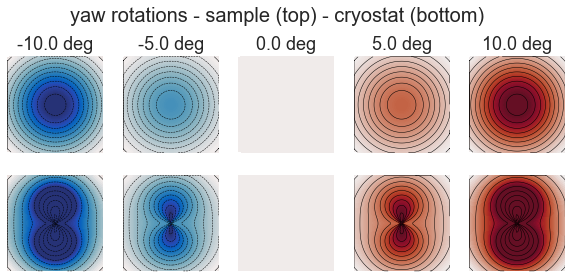

In [3]:
moment_direction, neutron_polarisation = [0, 1, 0], [1, 0, 0]
rotation_axis, num_rotations, delta_phi = 'yaw', 4, 5.
plot_property, col_limit = 'I_dif', 2.5

compare_rotations(moment_direction, neutron_polarisation, rotation_axis, num_rotations, delta_phi, plot_property, col_limit)

## ... one more example...

Here, a single sphere uniformly magnetised along (0, 0, 1), i.e. the vertical detector direction and a transverse neutron polarisation along (0, 1, 0), i.e. horizontal detector direction. The difference scattering patterns are obtained for “pitch” rotations which tilt the sample towards the detector.

In this example, the difference between tilting the sample and tilting of the cryostat is more subtle. 

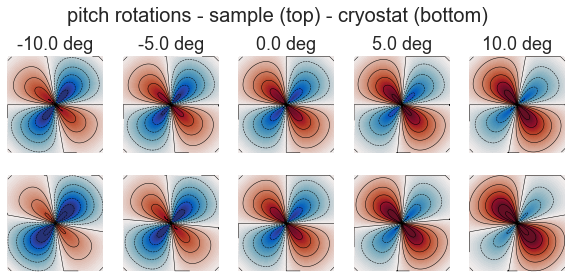

In [4]:
moment_direction, neutron_polarisation = [0, 0, 1], [0, 1, 0]
rotation_axis, num_rotations, delta_phi = 'pitch', 4, 5.
plot_property, col_limit = 'I_dif', 7.5

compare_rotations(moment_direction, neutron_polarisation, rotation_axis, num_rotations, delta_phi, plot_property, col_limit)